# The main objetive of this Analysis is to understand the factors which can influence or lead the Employee Attrition & Performance

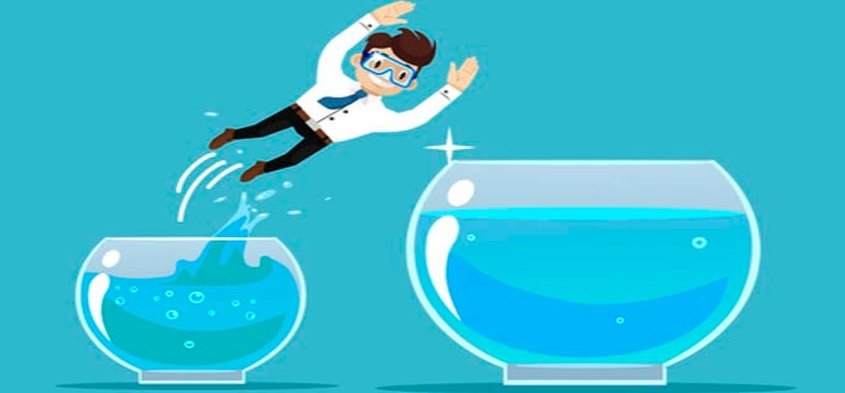

# Context = What is Attrition?
# Let´s simplify it as "Employee Turnover", so the attrition happens when the employee leaves the company for some reason.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
data = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
data.drop(['EmployeeCount'], axis=1, inplace= True) ### It is just a counter
data.drop(['StandardHours'], axis=1, inplace= True) ### It is the same value for all(80)
data.drop(['Over18'], axis=1, inplace= True) ### It is the same value for all(Yes)

In [ ]:
##### Importing the packages

import pandas as pd
from pandas import DataFrame
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import xgboost as xgb
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
data.Attrition.replace(to_replace = dict(Yes = 1, No = 0), inplace = True)

In [ ]:
data['Generation'] = data['Age']
data['Generation'] = data['Generation'].replace([18,19,20,21],'Z_18_to_21')
data['Generation'] = data['Generation'].replace([22,23,24,25,26,27,28,29,30,31,32,33,34,35,36],'Y_22_to_36')
data['Generation'] = data['Generation'].replace([37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56], 'X_37_to_56')
data['Generation'] = data['Generation'].replace([57,58,59,60],'Boomers_57_77')

### Creating additional Plots
Credits to: Vincent Lugat https://www.kaggle.com/vincentlugat/ibm-attrition-analysis-and-prediction


In [ ]:
attrition = data[(data['Attrition'] != 0)]
no_attrition = data[(data['Attrition'] == 0)]
def plot_distribution(var_select, bin_size) : 
# Calculate the correlation coefficient between the new variable and the target
    corr = data['Attrition'].corr(data[var_select])
    corr = np.round(corr,3)
    tmp1 = attrition[var_select]
    tmp2 = no_attrition[var_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Yes_attrition', 'No_attrition']
    colors = ['#00264d', '#00cc99']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, curve_type='kde', bin_size = bin_size)
    
    fig['layout'].update(title = var_select+' '+'(corr target ='+ str(corr)+')')

    py.iplot(fig, filename = 'Density plot')
    

In [ ]:
def barplot(var_select, x_no_numeric) :
    tmp1 = data[(data['Attrition'] != 0)]
    tmp2 = data[(data['Attrition'] == 0)]
    tmp3 = pd.DataFrame(pd.crosstab(data[var_select],data['Attrition']), )
    tmp3['Attr%'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100
    if x_no_numeric == True  : 
        tmp3 = tmp3.sort_values(1, ascending = False)

    color=['#00264d', '#00cc99' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        name='Yes_Attrition',opacity = 0.8, marker=dict(
        color='#00264d',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        name='No_Attrition', opacity = 0.8, marker=dict(
        color='#00cc99',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp3.index,
        y=tmp3['Attr%'],
        yaxis = 'y2',
        name='% Attrition', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% Attrition'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

In [ ]:
def High_Distance(data) :
    if data['DistanceFromHome'] > 10:
        return 1
    else:
        return 0
data['High_Distance'] = data.apply(lambda data:High_Distance(data) ,axis = 1)

def Young_Talents(data) :
    if data['Age'] < 25 :
        return 1
    else:
        return 0
data['Young_Talents'] = data.apply(lambda data:Young_Talents(data) ,axis = 1)

def Women_High_Traveller(data) : 
    if  data['Gender'] == 'Female' and data['BusinessTravel'] == 'Travel_Frequently':
        return 1
    else : 
        return 0
data['Women_High_Traveller'] = data.apply(lambda data:Women_High_Traveller(data) ,axis = 1)

def SamePositionforlongtime(data) :
    if data['YearsSinceLastPromotion'] > 5 :
        return 1
    else:
        return 0
data['SamePositionforlongtime'] = data.apply(lambda data:SamePositionforlongtime(data) ,axis = 1)

data['TotalSatisfaction_mean'] = (data['RelationshipSatisfaction']  + data['EnvironmentSatisfaction'] + data['JobSatisfaction'] + data['JobInvolvement'] + data['WorkLifeBalance'])/5

def NotSatif(data) : 
    if  data['TotalSatisfaction_mean'] < 2.5 :
        return 1
    else : 
        return 0
data['NotSatif'] = data.apply(lambda data:NotSatif(data) ,axis = 1)

def NotSatisfied_LongDistance(data) : 
    if  data['DistanceFromHome'] > 10 and data['NotSatif'] < 2.5 :
        return 1
    else : 
        return 0
data['NotSatisfied_LongDistance'] = data.apply(lambda data:NotSatisfied_LongDistance(data) ,axis = 1)

def OverTime_Sales(data) : 
    if  data['OverTime'] == 'Yes' and data['Department'] == 'Sales' :
        return 1
    else : 
        return 0
data['OverTime_Sales'] = data.apply(lambda data:OverTime_Sales(data) ,axis = 1)

def OverTime_HR(data) : 
    if  data['OverTime'] == 'Yes' and data['Department'] == 'Human Resources' :
        return 1
    else : 
        return 0
data['OverTime_HR'] = data.apply(lambda data:OverTime_HR(data) ,axis = 1)

def NotSatisfied_Overtime(data) : 
    if  data['OverTime'] =='Yes' and data['NotSatif'] < 2.5 :
        return 1
    else : 
        return 0
data['NotSatisfied_Overtime'] = data.apply(lambda data:NotSatisfied_Overtime(data) ,axis = 1)

# Summary

# Business Audience
### 0 - Explanatory Analysis

# Technical Audience
### 1 - Importing the Packages & Data  
### 2 - Dimension Understanding and setting the Expectations  
### 3 - Data Quality
### 4 - Data Exploration 
### 5 - Data Preparation
### 6 - Data Predictive Modelling

# 0 - Explanatory Analysis

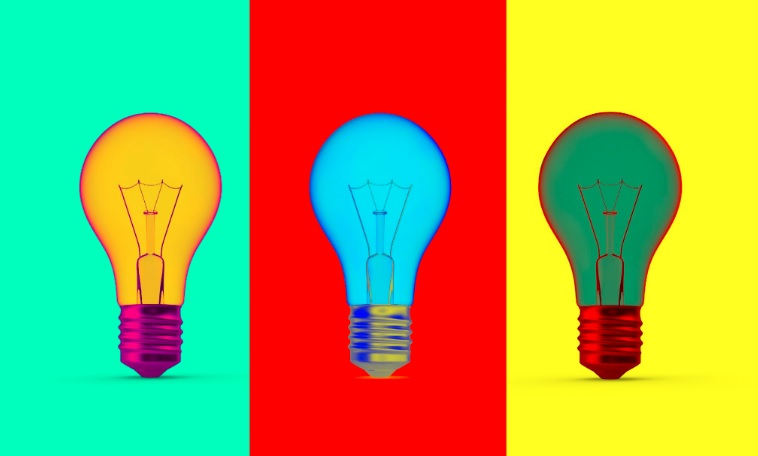

### 0.1 - Describe in 5 steps how the data is organized

#### There are 1470 records in the dataset and the following numbers of Attrition cases considering the Genders:

In [ ]:
barplot('Gender', False)

#### Departments and Job Levels are the following:

In [ ]:
barplot('Department', False)

In [ ]:
barplot('JobLevel', False)

# 3 - Regarding Distances and Travels we have the following information:

In [ ]:
plot_distribution('DistanceFromHome', False)

In [ ]:
barplot('BusinessTravel', False)

# 4 - The Environment Satisfaction is the following:

In [ ]:
barplot('EnvironmentSatisfaction', False)

# 5 - The Monthly income is distributed in this way across the job levels:

In [ ]:
# Boxplot
plt.title ('MonthlyIncome')
y = data.MonthlyIncome
x = data.JobLevel
fig = sns.boxplot(x,y,palette="Blues_d")
fig.axis(ymin=900, ymax=21999);

# 0.2 - What are the top most related to Attritions variables?

### When we talk about employees around 18 and 36 there is a high % of Attrition:

In [ ]:
barplot('Generation', False)

### It looks like the employees which are working overtime are very connected to the % of Attrition:

In [ ]:
barplot('OverTime', False)

### When there is a long distance between the job site and home, the % of Attrition is higher:

In [ ]:
barplot('DistanceFromHome', False)

### The same seem to be happening with people who are travelling frequently:

In [ ]:
barplot('BusinessTravel', False)

### The Sales and Human Resources departments are a higher % of Attrition:

In [ ]:
barplot('OverTime_Sales', False)

In [ ]:
barplot('OverTime_HR', False)

### Employees in the Job Level 1 have a high % of Attrition:

In [ ]:
barplot('JobLevel', False)

### Not Satisfied employees are directly linked to the % of Attrition:

In [ ]:
barplot('NotSatif', False)

# 0.3 - What are the main insights from "Personal Information" dimension?

### The Generations Y and Z have higher tendence to Attrition:

In [ ]:
barplot('Generation', False)

### The same happens for people which are working Overtime:

In [ ]:
barplot('OverTime', False)

# 0.4 - What are the main insights from "Timings Information" dimension?

### It looks like the first 2 years are crucial, when the employees keep working the in 
### the company for more than 2 years the potential of attrition decreases:

In [ ]:
barplot('YearsAtCompany', False)

# 0.5 - What are the main insights from "Distances and Travels" dimension?

### Employees facing long distances do comute are linked to Attritions:

In [ ]:
barplot('High_Distance', False)

### The same happens to women which are travelling frequently:

In [ ]:
barplot('Women_High_Traveller', False)

# 0.6 - What are the main insights from "Employee General Satisfaction" dimension?

### Employees not satisfied are leaving the company:

In [ ]:
barplot('NotSatif', False)

# 0.7 - What are the main insights from "Incomes" dimension?

### The Incomes are well distributed accross Job Levels and departments, 
### but it is not possible to determine if the employees are satisfied about it:

### Monthly Income per Job Level

In [ ]:
# Boxplot
plt.title ('MonthlyIncome')
y = data.MonthlyIncome
x = data.JobLevel
fig = sns.boxplot(x,y,palette="Blues_d")
fig.axis(ymin=900, ymax=21999);

### Statistics of Monthly Income per Sales Department

In [ ]:
data[(data.Department=='Sales')].MonthlyIncome.describe()

### Statistics of Monthly Income per HR Department

In [ ]:
data[(data.Department=='Human Resources')].MonthlyIncome.describe()

### Statistics of Monthly Income per R&D Department

In [ ]:
data[(data.Department=='Research & Development')].MonthlyIncome.describe()

# 0.8 - What are the main insights from "Newly created" dimension?

### Employees which are classified as High Distance(more than 10 KM to comute), 
### Young Talents (age until 25), Not Satisfied and working OverTime, 
### Overtime in Sales and HR departments are leading to cases of attrition.

In [ ]:
barplot('High_Distance', False)

In [ ]:
barplot('Young_Talents', False)

In [ ]:
barplot('NotSatif', False)

In [ ]:
barplot('OverTime_Sales', False)

In [ ]:
barplot('OverTime_HR', False)

# 0.9 - Is it possible to predict which employee is closer to a Attrition case?

### I´ve created a Predictive Modelling which have a Good Accuracy but unfortunately is still have some dificults to predict True Positive Cases (Cases of Attrition), so its Precision Metric is still poor:

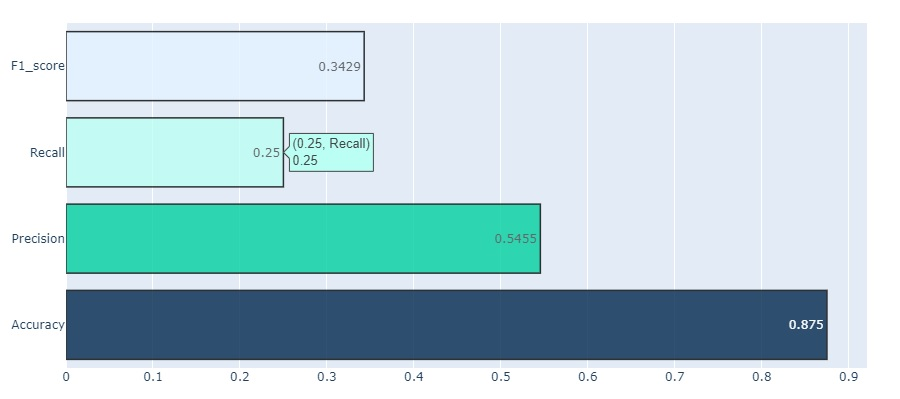

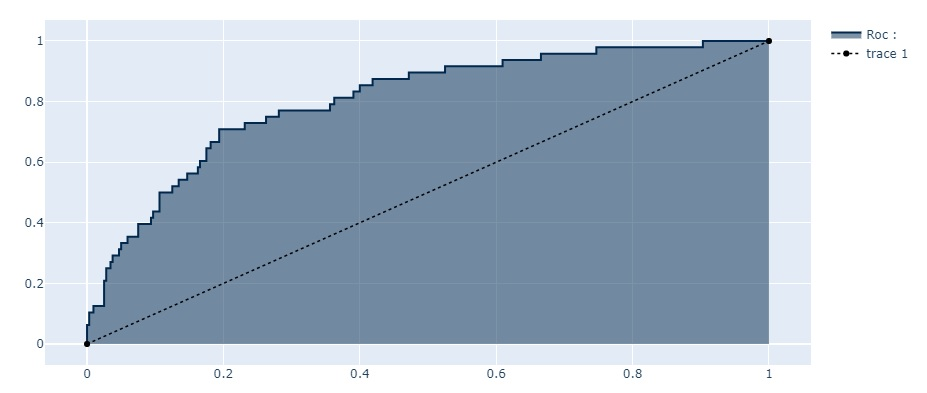

# Accordingly to the Predicive Model, below are the most import features:

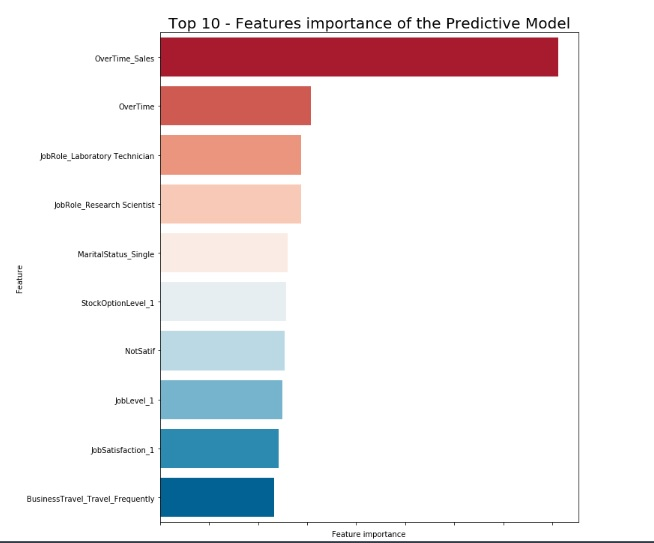

# Conclusion:
### The analysis above explains how some employees variables are related to the % of Attrition and gives some valuable hints to the leadership on how to prioritize and deal with the possible risks involved on it.

### Below I will detail in a technical way how I got these results:

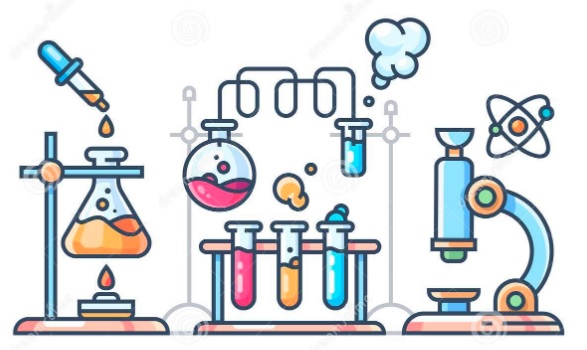

# 2 - Dimension Understanding and setting the Expectations (Business Audience)

### Looking the the Dataframe we can separate the data in some Dimension and inform  our expectation about it (high, medium ,low)

### Explanation about the levels of expectation:
### High: 
#### This variable is showing very important information for the context of Employee Attrition, so it will be important to this model and analysis. 

### Medium: 
#### This variable is showing quite information for the context of Employee Attrition, so it can be important to this model but won´t be priotized in this analysis.

### Low: 
#### This variable is not showing relevant information for the context of Employee Attrition

# Dimension - Personal Information
#### Age - Expectation "High"
#### Gender  - Expectation "High"
#### MaritalStatus - Expectation "Low"
#### Over18 - Expectation "Low"
#### OverTime - Expectation "High"

# Dimension - Timings Information

#### TotalWorkingYears - Expectation "Medium"
#### YearsAtCompany - Expectation "High"
#### YearsInCurrentRole - Expectation "High"
#### YearsSinceLastPromotion - Expectation "High"
#### YearsWithCurrManager - Expectation "Medium"
#### NumCompaniesWorked - Expectation "Medium"

# Dimension - Distances and Travels
#### BusinessTravel - Expectation "High"
#### DistanceFromHome - Expectation "High"

# Dimension - Employee General Satisfaction
#### Department - Expectation "High"
#### EmployeeNumber - Expectation "Low - Can be removed"
#### EmployeeCount - Expectation "Low - Can be removed"
#### EnvironmentSatisfaction - Expectation "High"
1 = 'Low' ;
2 = 'Medium' ;
3 = 'High';
4 ='Very High'


#### WorkLifeBalance - Expectation "High"
1 = 'Bad' ;
2 = 'Good' ;
3 = 'Better' ;
4 = 'Best' 
#### JobSatisfaction - Expectation "High"
1 = 'Low' ;
2 = 'Medium' ;
3 = 'High' ;
4 = 'Very High' 
#### JobRole - Expectation "Low"
#### JobLevel - Expectation "High" ;
1 = level_1 ;
2 = level_2 ;
3 = level_3 ;
4 = level_4 ;
5 = level_5 
#### JobInvolvement - Expectation "Low"
1 = 'Low' ; 
2 = 'Medium' ;
3 = 'High' ;
4 = 'Very High'

#### PerformanceRating -   Expectation "High"
1 = 'Low'
2 = 'Good'
3 = 'Excellent'
4 = 'Outstanding'

#### RelationshipSatisfaction -   Expectation "High"
1 = 'Low' ;
2 = 'Medium' ;
3 = 'High' ;
4 = 'Very High' 

# Dimension - Incomes
#### DailyRate - Expectation "High" - But we already have "Monthly Income", so it can be ignored.
#### HourlyRate - Expectation "High"  - But we already have "Monthly Income", so it can be ignored.
#### MonthlyIncome - Expectation "High"
#### MonthlyRate - Expectation "High"  - But we already have "Monthly Income", so it can be ignored.
#### StockOptionLevel - Expectation "High"
#### StandardHours - Expectation "Low"
#### PercentSalaryHike - Expectation "Medium"

# Dimension - Education
#### Education- Expectation "Medium"
Education
1 = 'Below College';
2 = 'College' ;
3 = 'Bachelor' ;
4 = 'Master' ;
5 = 'Doctor' ;



#### EducationField - Expectation "Medium"
 

# 3 - Data Quality (Technical Audience)

# 3.1 - Looking for Missing Values which can impact our analysis

In [ ]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(
ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

Conclusion: There is no Missing Values in the dataset

#  4 - Data Exploration (Technical Audience)

# 4.1 - Data Exploration - Dimension "Personal Information"

# 4.1.1 - Analysis of Age

In [ ]:
data.Age.describe()

In [ ]:
data_personal = DataFrame(data, columns = ['Age'])
g = sns.pairplot(data_personal, diag_kind="kde", markers="+",
                 plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                 diag_kws=dict(shade=True))


In [ ]:
# Curtosis
scipy.stats.kurtosis(data.Age)

#### b < 0, so the distribution function is more flattened than the normal 
####distribution. We say that this distribution function curve is platicurtic

In [ ]:
#### Skewness
scipy.stats.skew(data.Age)

#### A positive value for asymmetry indicates that the tail on the right side is larger than the tail on the left

In [ ]:
#### Below we can see that there is a slight difference between the Age boxplots considering the attritions(yes or no).
#### Maybe younger people are having more attrition cases.
y = data.Age
x = data.Attrition
fig = sns.boxplot(x,y,palette="Blues_d")
fig.axis(ymin=15, ymax=65);

#### Creating some Bins related to the Age variable

The dataset is from 2017.
I will a variable called generation, and the it will be divided as follows:
##### Baby_Boomers (born between 1940 and 1960 ) = So, they were in 2017 between 57 and 77 years old.
##### X_Generation (born between 1961 and 1980) = So, they were in 2017 between 37 and 56 years old.
##### Y_Millenials_Generation (born between 1981 and 1995 ) = So, they were in 2017 between 22 and 36 years old.
##### Z_Generation (born between 1996 and 2010 ) = So, they were in 2017 between 7 and 21 years old.

Source:https://rockcontent.com/blog/dossie-das-geracoes/


In [ ]:
data.Generation.unique()

##### What Generations and which quantity per generation do we have in the dataset?

In [ ]:
grafico = sns.countplot(data = data , x = 'Generation', hue = 'Generation', palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

##### How are the main statistics when we compare Attrition vs Age

In [ ]:
data.groupby('Attrition')[['Age']].describe()

##### As we could see in the boxplot analysis and in this previous comparison beetween Atttrition and Age, there is a slight difference when comparing the ages and attrition.

##### What are  % of Attrition considering all the Age Distribution? 

In [ ]:
barplot('Age', False)

In [ ]:
plot_distribution('Age', False)

In [ ]:
barplot('Generation', False)

##### Looking to these graphs and numbers, it looks that the % of Attrition is higher when we are talking about employees around 18 and 35 years old.

# 4.1.2 - Analysis of Gender

In [ ]:
grafico = sns.countplot(data = data , x = 'Gender', hue = 'Gender',palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
barplot('Gender', False)

In [ ]:
data[(data.Gender=='Male')].groupby('Attrition')[['Age']].describe()

In [ ]:
data[(data.Gender=='Female')].groupby('Attrition')[['Age']].describe()

# 4.1.3 - Analysis of OverTime

In [ ]:
grafico = sns.countplot(data = data , x = 'OverTime', hue = 'OverTime',palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
barplot('OverTime', False)

##### Looking to the numbers and the graphs I do not see significant differences between the Genders results, despite the fact that there are more Male(882) than Female(588) employees.

# Conclusion of the Analysis in the dimension "Personal Information":
Looking to the variables we´ve selected and High Expectation, only the variable Age and OverTime have shown significant information, mainly showing the fact that the generations Z(18 until 21) and Y(22 until 36) have a higher %Attrition when comparting to the other generations and the fact that people working Overtime has a greater % of Attrition

#  4.2 - Data Exploration - Dimension "Timing Information"

# 4.2.1 - YearsAtCompany , YearInCurrentRole, YearsSinceLastPromotion

In [ ]:
data_timings1 = DataFrame(data, columns = ['YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion'])
g = sns.pairplot(data_timings1, diag_kind="kde", markers="+",
                 plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                 diag_kws=dict(shade=True))

In [ ]:
data_timings1.describe()

In [ ]:
# Boxplot

plt.title ('YearsAtCompany')
y = data.YearsAtCompany
x = data.Attrition
fig = sns.boxplot(x,y,palette="Blues_d")
fig.axis(ymin=0, ymax=40);

In [ ]:
plt.title ('YearsInCurrentRole')
y = data.YearsInCurrentRole
x = data.Attrition
fig = sns.boxplot(x,y,palette="Blues_d")
fig.axis(ymin=0, ymax=18);

In [ ]:
plt.title ('YearsSinceLastPromotion')
y = data.YearsSinceLastPromotion
x = data.Attrition
fig = sns.boxplot(x,y,palette="Blues_d")
fig.axis(ymin=-2, ymax=15);

In [ ]:
barplot('YearsAtCompany', False)

In [ ]:
barplot('YearsInCurrentRole', False)

In [ ]:
barplot('YearsSinceLastPromotion', False)

In [ ]:
plot_distribution('YearsAtCompany', False)

In [ ]:
plot_distribution('YearsInCurrentRole', False)

In [ ]:
plot_distribution('YearsSinceLastPromotion', False)

# 4.3 - Data Exploration - Dimension - Distances and Travels

# 4.3.1 - Analysis of DistanceFromHome and BusinessTravel

In [ ]:
data_distances = DataFrame(data, columns = ['DistanceFromHome'])
g = sns.pairplot(data_distances, diag_kind="kde", markers="+",
                 plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                 diag_kws=dict(shade=True))

In [ ]:
data_distances.describe()

In [ ]:
# Boxplot

plt.title ('Distances')
y = data.DistanceFromHome
x = data.Attrition
fig = sns.boxplot(x,y,palette="Blues_d")
fig.axis(ymin=1, ymax=30);

In [ ]:
barplot('DistanceFromHome', False)

In [ ]:
plot_distribution('DistanceFromHome', False)

In [ ]:
grafico = sns.countplot(data = data , x = 'BusinessTravel', hue = 'BusinessTravel',palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
barplot('BusinessTravel', False)

# 4.4 - Data Exploration - Dimension - Employee General Satisfaction

# 4.4.1 - Analysis of Departament, EnvironmentSatisfaction, WorklifeBalance, JobSatisfaction, JobLevel, PerformanceRating, RelationshipSatisfaction

In [ ]:
grafico = sns.countplot(data = data , x = 'Department', hue = 'Department',palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
grafico = sns.countplot(data = data , x = 'EnvironmentSatisfaction', hue = 'EnvironmentSatisfaction',palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
grafico = sns.countplot(data = data , x = 'WorkLifeBalance', hue = 'WorkLifeBalance',palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
grafico = sns.countplot(data = data , x = 'JobSatisfaction', hue = 'JobSatisfaction',palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
grafico = sns.countplot(data = data , x = 'JobLevel', hue = 'JobLevel',palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
grafico = sns.countplot(data = data , x = 'PerformanceRating', hue = 'PerformanceRating', palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
grafico = sns.countplot(data = data , x = 'RelationshipSatisfaction', hue = 'RelationshipSatisfaction',palette="Blues_d")

for p in grafico.patches:
	b=p.get_bbox()
	grafico.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.show()

In [ ]:
barplot('Department', False)

In [ ]:
barplot('EnvironmentSatisfaction', False)

In [ ]:
barplot('WorkLifeBalance', False)

In [ ]:
barplot('JobSatisfaction', False)

In [ ]:
barplot('JobLevel', False)

In [ ]:
barplot('PerformanceRating', False)

In [ ]:
barplot('PerformanceRating', False)

# 4.5 - Data Exploration - Dimension - Incomes

# 4.5.1 - Analysis of MonthlyIncome, StockOptionLevel

In [ ]:
data_income = DataFrame(data, columns = ['MonthlyIncome'])
g = sns.pairplot(data_income, diag_kind="kde", markers="+",
                 plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                 diag_kws=dict(shade=True))

In [ ]:
data_income.describe()

In [ ]:
# Boxplot

plt.title ('MonthlyIncome')
y = data.MonthlyIncome
x = data.Attrition
fig = sns.boxplot(x,y,palette="Blues_d")
fig.axis(ymin=900, ymax=21999);

In [ ]:
# Boxplot
plt.title ('MonthlyIncome')
y = data.MonthlyIncome
x = data.JobLevel
fig = sns.boxplot(x,y,palette="Blues_d")
fig.axis(ymin=900, ymax=21999);

In [ ]:
data[(data.Department=='Sales')].MonthlyIncome.describe()

In [ ]:
data[(data.Department=='Human Resources')].MonthlyIncome.describe()

In [ ]:
data[(data.Department=='Research & Development')].MonthlyIncome.describe()

In [ ]:
plot_distribution('MonthlyIncome', False)

In [ ]:
barplot('StockOptionLevel', False)

# 4.6 - Adding new Dimensions: 
### High_Distance - Employees which take more than 10KM to comute.
### Young_Talents - Employees younger than 25.
### Women_High_Travelers - Women which are Travelling Frequently
### SamePositionforlongtime - Employees which are in the same position for more than 5 years
### NotSatisf - Employees which have a Satisfaction Average less than 2.5
### NotSatisf_LongDistance - Employees which have a Satisfaction Average less than 2.5 and are taking more than 10km to comute
### NotSatisf_OverTime - Employees which have a Satisfaction Average less than 2.5 and are working Overtime.
### OverTime_Sales - Employees from Sales Department which are working OverTime.
### OverTime_HR - Employees from Human Resources which are working OverTime.

# 4.7 -  Data Exploration - New Dimensions

In [ ]:
barplot('High_Distance', False)

In [ ]:
barplot('Young_Talents', False)

In [ ]:
barplot('Women_High_Traveller', False)

In [ ]:
barplot('SamePositionforlongtime', False)

In [ ]:
barplot('NotSatif', False)

In [ ]:
barplot('NotSatisfied_Overtime', False)

In [ ]:
barplot('NotSatisfied_LongDistance', False)

In [ ]:
barplot('OverTime_Sales', False)

In [ ]:
barplot('OverTime_HR', False)

# 5 - Data Preparation

# 5.1 - Dummy Variables and Normalization

In [ ]:
#customer id col
Id_col     = ['EmployeeNumber']
#Target columns
target_col = ["Attrition"]
#categorical columns
cat_cols   = data.nunique()[data.nunique() < 10].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")
data = data.drop(['EmployeeNumber'],axis = 1)

# 5.2 - Reducing Multicollinearity

# 5.2.1 - Correlation Matrix 

In [ ]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale='Cividis_r',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        #height  = 1400,
                        #width   = 1600,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 30,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

# 5.2.2 - Removing Multicolinearity

In [ ]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = data.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove :' % (len(to_drop)))

data = data.drop(columns = to_drop)

to_drop

# 5.4 - Defining the Test and Train datasets and variables X and Y

# 5.4.1 - Defining X and Y

In [ ]:
# Def X and Y
y = np.array(data.Attrition.tolist())
data = data.drop('Attrition', 1)

In [ ]:
X = data.to_numpy()


# 5.4.2 - Defining Test and Train datasets

In [ ]:
# Train_test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)

# 6 - Data Predictive Modelling

# 6.1 - Identifying the best parameters to the Predictive Model

In [ ]:
#### Defining the Parameters
param_grid = {'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.25],
              'max_depth': [3,4, 5, 6,10],
              'min_child_weight': [1, 5, 7, 10],
              'gamma': [0.1, 0.5, 1, 1.5, 5],
              'min_samples_leaf': [3, 4, 5],
              'subsample': [0.3, 0.5, 0.7],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'n_estimators': [100, 300, 750, 1000]
              }

# Defining the Xtreme Gradiente Boosting Classifier as 'est'
est = xgb.XGBClassifier()

# GridSearchCV model
# gs_cv = RandomizedSearchCV(est, param_distributions=param_grid, n_iter=800, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42).fit(X_train, y_train)


# Printing the Best Parameters
#print('Melhores Hiperparâmetros: %r' % gs_cv.best_params_)

# 6.2 - Running Predictive Model using Xtreme Gradient Boosting Classifier

In [ ]:
#### Informing the parameters
xgb_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                           colsample_bytree=0.6, gamma=1, learning_rate=0.1,
                           max_delta_step=0, max_depth=3, min_samples_leaf=5, min_child_weight=7, missing=None,
                           n_estimators=300, n_jobs=-1, nthread=None,
                           objective='binary:logistic', random_state=0, reg_alpha=0,
                           reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                           subsample=0.3)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_score = xgb_clf.predict_proba(X_test)[:,1]

# 6.3 - Cross Validation Metrics

In [ ]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

#Metrics
tp = conf_matrix[1,1]
fn = conf_matrix[1,0]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
Precision =  (tp/(tp+fp))
Recall    =  (tp/(tp+fn))
F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
show_metrics = show_metrics.T


In [ ]:
conf_matrix

In [ ]:
colors = ['#00264d', '#00cc99' , '#ccfff2', '#e6f2ff']
Metrics = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
fig1 = go.Figure(data = [Metrics])
fig1.show()

# 6.4 - ROC Curve

In [ ]:
#ROC Curve
model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
fpr, tpr, t = roc_curve(y_test, y_score)
ROC = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : ",
                        line = dict(color = '#00264d',width = 2), fill='tozeroy')
ROC1 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
fig2 = go.Figure(data = [ROC,ROC1])
fig2.show()

# 6.5 - Feature Importance

In [ ]:
 #feature importance plot TOP 10
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

tmp = pd.DataFrame({'Feature': list(data), 'Feature importance': xgb_clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False).head(10)
plt.figure(figsize = (10,12))
plt.title('Top 10 - Features importance of the Predictive Model',fontsize=20)
s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h', palette="RdBu"  )
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

This is the end of this Kernel and I would like to thank you to spend some minutes here and thank you again @VicentLugat for the inspiration on how to handle this analysis.

